In [1]:
#import needed libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#open json file 
f = open(r"C:\Users\reigne\Desktop\ITMGT\Ad Hoc Analysis\transaction-data-adhoc-analysis.json")
data = json.load(f)
df = pd.DataFrame(data)

#dump 
df.head()

,address,birthdate,mail,name,sex,username,transaction_items,transaction_value,transaction_date
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,"Exotic Extras,Beef Chicharon,(x4)",5196,2022/01/12
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"Exotic Extras,Beef Chicharon,(x3);HealthyKid 3...",12056,2022/01/12
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Gummy Vitamins,(x3);HealthyKid 3...",5500,2022/01/08
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Yummy Vegetables,(x1)",500,2022/01/10
4,"33911 Hansen Loaf\nWest Sandra, ND 54188",1949/09/27,michael78@yahoo.com,Kristen Cooper,F,qhernandez,"Candy City,Orange Beans,(x3);Candy City,Gummy ...",2697,2022/01/24


In [3]:
#split transaction items (https://datascienceparichay.com/article/pandas-split-column-by-delimiter/#:~:text=Split%20column%20by%20delimiter%20into,True%20to%20the%20expand%20parameter.)
items_df = df.copy()
items_df["transaction_items"] = items_df["transaction_items"].str.split(";")

#explode dataframe to separate column values into multiple rows (https://cmdlinetips.com/2020/06/pandas-explode-convert-list-like-column-elements-to-separate-rows/)
items_df = items_df.explode("transaction_items").reset_index(drop=True)
cols = list(items_df.columns)
items_df = items_df[cols]

In [4]:
#split by brand, product, and quantity 
items_df["transaction_items"].str.split(",", expand=True)
items_df[["brand", "product", "quantity"]] = items_df["transaction_items"].str.split(",", expand=True)

#remove unnecessary symbols (https://stackoverflow.com/questions/20894525/how-to-remove-parentheses-and-all-data-within-using-pandas-python)
#convert quantity to integers (https://datatofish.com/string-to-integer-dataframe/)
items_df["quantity"] = items_df["quantity"].str.replace("[(,),x]", "", regex=True).astype(int)

#extract month from transaction date (https://www.interviewqs.com/ddi-code-snippets/extract-month-year-pandas)
items_df["month"] = pd.DatetimeIndex(items_df["transaction_date"]).month

In [5]:
#group by month and product, then get the sum of quantity to obtain the count of each item sold per month (https://www.statology.org/pandas-groupby-sum/)
items_count = items_df.groupby(["month", "product"])["quantity"].sum()
items = items_count.unstack()

#dump
items

product,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables
month,,,,,,,
1,9665,9681,9559,9676,9727,9774,9959
2,10001,9980,9996,9949,9691,10037,10256
3,9816,10145,9986,9967,9876,9611,9896
4,9890,9842,10043,9921,9786,9914,9861
5,10028,9948,9801,9773,9881,9964,9735
6,9902,9980,9934,10104,9767,10106,9722


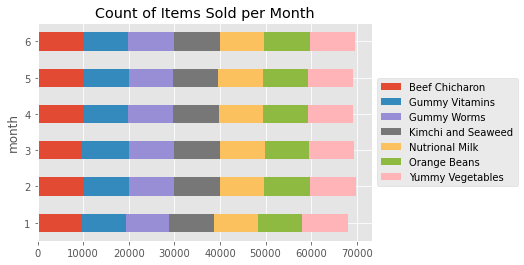

In [6]:
#use matplotlib style sheet (https://stackoverflow.com/questions/15814635/prettier-default-plot-colors-in-matplotlib)
plt.style.use("ggplot")

#generate bar graph 
items.plot.barh(stacked=True)

#put legend outside since it was blocking the chart (https://pythonguides.com/put-legend-outside-plot-matplotlib/)
plt.legend(bbox_to_anchor=(1,0.5), loc="center left")
plt.title("Count of Items Sold per Month")

#save figure without legend getting cut off (https://stackoverflow.com/questions/6774086/how-to-adjust-padding-with-cutoff-or-overlapping-labels)
plt.savefig("items_count.png", bbox_inches="tight")

In [7]:
#make a copy of df to determine product price
product_price = df[["transaction_items", "transaction_value"]].copy()

#check if transaction items contain specific products 
product_price["BC"] = product_price["transaction_items"].str.contains("Beef Chicharon")
product_price["GV"] = product_price["transaction_items"].str.contains("Gummy Vitamins")
product_price["GW"] = product_price["transaction_items"].str.contains("Gummy Worms")
product_price["KS"] = product_price["transaction_items"].str.contains("Kimchi and Seaweed")
product_price["NM"] = product_price["transaction_items"].str.contains("Nutrional Milk")
product_price["OB"] = product_price["transaction_items"].str.contains("Orange Beans")
product_price["YV"] = product_price["transaction_items"].str.contains("Yummy Vegetables")

#count number of products in transaction items 
products = ["BC", "GV", "GW", "KS", "NM", "OB", "YV"]
product_price["products_count"] = product_price[products].sum(axis=1)

#get transactions with only one kind of product 
product_price = product_price[product_price["products_count"] == 1]

#split by brand, product, and quantity
product_price["transaction_items"].str.split(",", expand=True)
product_price[["brand", "product", "quantity"]] = product_price["transaction_items"].str.split(",", expand=True)
product_price["quantity"] = product_price["quantity"].str.replace("[(,),x]", "", regex=True).astype(int)
product_price = product_price[["brand", "product", "quantity", "transaction_value"]]

#divide transaction value by quantity to get price per product 
product_price["price"] = product_price["transaction_value"]/product_price["quantity"]
product_price = product_price[["product", "price"]]

#drop duplicates to obtain final price list (https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/)
product_price.drop_duplicates(subset="product", keep="first", inplace=True)

#dump
product_price

,product,price
0,Beef Chicharon,1299.0
3,Yummy Vegetables,500.0
6,Kimchi and Seaweed,799.0
8,Gummy Worms,150.0
11,Gummy Vitamins,1500.0
18,Nutrional Milk,1990.0
19,Orange Beans,199.0


In [8]:
#merge tables (https://datacarpentry.org/python-socialsci/11-joins/index.html)
total_sales = pd.merge(items_count.reset_index(), product_price, on="product", how="inner")

#multiply quantity by product price to get monthly sales 
total_sales["monthly_sales"] = total_sales["quantity"]*total_sales["price"]

#construct pivot table (https://stackoverflow.com/questions/66411797/is-there-an-alternative-more-efficient-way-to-unstack-columns-from-a-multiindex)
sales = pd.pivot_table(total_sales, values="monthly_sales", index="month", columns="product")

#dump
sales

product,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables
month,,,,,,,
1,12554835.0,14521500.0,1433850.0,7731124.0,19356730.0,1945026.0,4979500.0
2,12991299.0,14970000.0,1499400.0,7949251.0,19285090.0,1997363.0,5128000.0
3,12750984.0,15217500.0,1497900.0,7963633.0,19653240.0,1912589.0,4948000.0
4,12847110.0,14763000.0,1506450.0,7926879.0,19474140.0,1972886.0,4930500.0
5,13026372.0,14922000.0,1470150.0,7808627.0,19663190.0,1982836.0,4867500.0
6,12862698.0,14970000.0,1490100.0,8073096.0,19436330.0,2011094.0,4861000.0


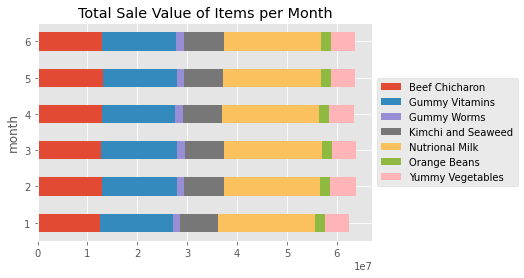

In [9]:
#generate bar graph
sales.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1,0.5), loc="center left")
plt.title("Total Sale Value of Items per Month")
plt.savefig("total_sales.png", bbox_inches="tight")

In [10]:
#make a copy of df with only the name and transaction date 
date_df = df[["name", "transaction_date"]].copy()
date_df["month"] = pd.DatetimeIndex(date_df["transaction_date"]).month
date_df.drop(columns=["transaction_date"], inplace=True)

#group customer names by their month of purchase (https://www.adamsmith.haus/python/answers/how-to-group-rows-from-a-pandas-dataframe-into-lists-by-column-value-in-python)
date_df = date_df.groupby("month")
date_df = date_df["name"].unique().apply(list)
date_df = date_df.reset_index()

#get raw count of customers who purchased per month
date_df["customers"] = date_df["name"].apply(lambda x: len(x))

#dump
date_df

,month,name,customers
0,1,"[Jennifer Campbell, Melissa Kim, Kristen Coope...",6588
1,2,"[Jennifer Campbell, Melissa Kim, Kristen Coope...",6631
2,3,"[Jennifer Campbell, Melissa Kim, Kristen Coope...",6622
3,4,"[Melissa Kim, Kristen Cooper, Alexander Davis,...",6556
4,5,"[Melissa Kim, Kristen Cooper, Alexander Davis,...",6568
5,6,"[Jennifer Campbell, Alexander Davis, Michael L...",6652


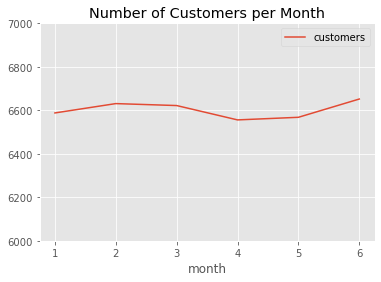

In [11]:
#generate line graph 
date = date_df[["month", "customers"]]
date = date.set_index("month")
date.plot()
plt.title("Number of Customers per Month")

#set axis range (https://www.statology.org/matplotlib-set-axis-range/)
plt.ylim(6000, 7000)
plt.savefig("customers.png")

In [12]:
#define months as variables based on their positions
month1 = date_df.iloc[0,1]
month2 = date_df.iloc[1,1]
month3 = date_df.iloc[2,1]
month4 = date_df.iloc[3,1]
month5 = date_df.iloc[4,1]
month6 = date_df.iloc[5,1]

In [13]:
#get repeaters 
def repeaters(date_df):
    rep1 = 0
    rep2 = 0
    rep3 = 0
    rep4 = 0
    rep5 = 0
    rep6 = 0
    
    for customer in month2:
        if customer in month2 and customer in month1:
            rep2 += 1
            
    for customer in month3:
        if customer in month3 and customer in month2:
            rep3 += 1
    
    for customer in month4:
        if customer in month4 and customer in month3:
            rep4 += 1

    for customer in month5:
        if customer in month5 and customer in month4:
            rep5 += 1
    
    for customer in month6:
        if customer in month6 and customer in month5:
            rep6 += 1
      
    return (rep1, rep2, rep3, rep4, rep5, rep6) 

In [14]:
#dump repeaters 
repeaters(date_df)

(0, 5172, 5216, 5154, 5110, 5193)

In [15]:
#get inactive
def inactive(date_df):
    in1 = 0
    in2 = 0
    in3 = 0
    in4 = 0
    in5 = 0
    in6 = 0
    
    for customer in month1:
        if customer not in month2 and customer in month1:
            in2 += 1
            
    for customer in month1:
        if customer not in month3 and (customer in month1 or customer in month2):
            in3 += 1
    
    for customer in month1:
        if customer not in month4 and (customer in month1 or customer in month2 or customer in month3):
            in4 += 1

    for customer in month1:
        if customer not in month5 and (customer in month1 or customer in month2 or customer in month3 or customer in month4):
            in5 += 1
    
    for customer in month1:
        if customer not in month6 and (customer in month1 or customer in month2 or customer in month3 or customer in month4 or customer in month5):
            in6 += 1
      
    return (in1, in2, in3, in4, in5, in6)

In [16]:
#dump inactive
inactive(date_df)

(0, 1416, 1378, 1437, 1445, 1393)

In [17]:
#get engaged 
def engaged(date_df):
    eng1 = 0
    eng2 = 0
    eng3 = 0
    eng4 = 0
    eng5 = 0
    eng6 = 0
    
    for customer in month1:
        if customer in month1:
            eng1 += 1
            
    for customer in month2:
        if customer in month1 and customer in month2:
            eng2 += 1
            
    for customer in month3:
        if customer in month1 and customer in month2 and customer in month3:
            eng3 += 1
    
    for customer in month4:
        if customer in month1 and customer in month2 and customer in month3 and customer in month4:
            eng4 += 1

    for customer in month5:
        if customer in month1 and customer in month2 and customer in month3 and customer in month4 and customer in month5:
            eng5 += 1
    
    for customer in month6:
        if customer in month1 and customer in month2 and customer in month3 and customer in month4 and customer in month5 and customer in month6:
            eng6 += 1
      
    return (eng1, eng2, eng3, eng4, eng5, eng6)

In [18]:
#dump engaged 
engaged(date_df)

(6588, 5172, 4126, 3289, 2667, 2190)

In [19]:
#create customers table 
customers = pd.DataFrame()
customers["Month"] = ["Jan","Feb","Mar","Apr","May","Jun"]
customers["Repeaters"] = repeaters(date_df)
customers["Inactive"] = inactive(date_df)
customers["Engaged"] = engaged(date_df)
customers = customers.set_index("Month")
customers.transpose()

Month,Jan,Feb,Mar,Apr,May,Jun
Repeaters,0,5172,5216,5154,5110,5193
Inactive,0,1416,1378,1437,1445,1393
Engaged,6588,5172,4126,3289,2667,2190


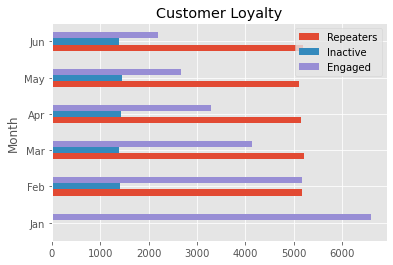

In [20]:
#generate bar graph 
customers.plot.barh()
plt.title("Customer Loyalty")
plt.savefig("customer_loyalty.png")